# Ejercicio de GAM
**Integrantes**: Maria Fernanda Rodriguez, Dayana Valentina Gonzalez

In [84]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.gam.api import GLMGam, BSplines
from patsy import dmatrix
from collections import defaultdict
from operator import itemgetter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
# from pandas import scatter_matrix 

%matplotlib inline
plt.style.use('ggplot')

### Función para ayudar a graficar una matriz de dispersión usando el modelo GAM
La siguiente función puede serle útil para aplicarla al modelo (en el punto b)

In [8]:
def gam_plot(data, design, gam_model, predictors):
    """
    A method to plot fitted basis functions similar to R's gam library and associated plot method.
    
    Parameters:
        data:       Original DataFrame containing all features.
        design:     An n_samples by n_features design dataframe with basis functions created using Patsy.
        gam_model:  A statsmodel fitted OLS object. 
        predictors: A list of string names for each of the predictors used to construct the gam.        

    """
    basis_funcs = defaultdict(np.array,[])
    extremums = defaultdict(list)
    
    # Compute the product of the design df with the coeffecients
    results = design * gam.params
    # find the columns that have the predictor in the col name and get the results from these columns
    for predictor in predictors:
        column_names = [col for col in design.columns if predictor in col]
        basis_funcs[predictor] = results[column_names]
        
        
    # Plotting
    num_rows = len(predictors)//3 + 1 if len(predictors)%3!=0 else len(predictors)//3
    fig, axarr = plt.subplots(num_rows, 3, figsize=(12,8))
    
    for el, predictor in enumerate(predictors):
        # get the tuple index to plot to
        plt_index = np.unravel_index(el,(num_rows, 3))
        
        # numeric predictors
        if data[predictor].values.dtype.type is np.int64:
            # get the order of the predictor and make a grid
            order = np.argsort(data[predictor])
            predictor_grid = data[predictor].values[order]
            # sum the basis functions and order the same as the predictor
            basis_vals = np.sum(basis_funcs[predictor].values, axis=1)[order]
            axarr[plt_index[0], plt_index[1]].plot(predictor_grid, basis_vals)
            
        else:
            # categorical predictors
            # make a temporary data frame
            s = pd.DataFrame(data[predictor])
            # add the sum of the basis functions for this categorical predictor
            s['f-'+predictor] = np.sum(basis_funcs[predictor].values, axis=1)
            # zero-mean
            s['f-'+predictor] = s['f-'+predictor] - s['f-'+predictor].mean()
            # call boxplot grouping by predictor col
            s.boxplot(column=['f-'+predictor], by=predictor, ax = axarr[plt_index[0], plt_index[1]]);
            axarr[plt_index[0], plt_index[1]].set_ylabel('F%d(%s)' %(el,predictor));
            plt.suptitle('')
            
        # Add Labels
        axarr[plt_index[0], plt_index[1]].set_xlabel(predictor);
        axarr[plt_index[0], plt_index[1]].set_ylabel('F%d(%s)' % (el,predictor));
        plt.tight_layout() 
                
    return basis_funcs

**[1]** Reproduzca el modelo de GAM realizado anteriormente usando `GLMGam`.

### Importar datos de WAGE

In [9]:
Wages = pd.read_csv('Wage.csv', index_col=0)
Wages.reset_index(inplace=True)
Wages.head()

,index,year,age,sex,maritl,race,education,region,jobclass,health,health_ins,logwage,wage
0,231655,2006,18,1. Male,1. Never Married,1. White,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.318063,75.043154
1,86582,2004,24,1. Male,1. Never Married,1. White,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,2. No,4.255273,70.476020
2,161300,2003,45,1. Male,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,1. <=Good,1. Yes,4.875061,130.982177
3,155159,2003,43,1. Male,2. Married,3. Asian,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,1. Yes,5.041393,154.685293
4,11443,2005,50,1. Male,4. Divorced,1. White,2. HS Grad,2. Middle Atlantic,2. Information,1. <=Good,1. Yes,4.318063,75.043154


In [11]:
# rename the 'Unnamed: 0' col to 'id'
Wages = Wages.rename(columns={'Unnamed: 0': 'id'})

# find out if there are any missing values
print(pd.isnull(Wages).any())

index         False
year          False
age           False
sex           False
maritl        False
race          False
education     False
region        False
jobclass      False
health        False
health_ins    False
logwage       False
wage          False
dtype: bool


#### Primero ejemplo 

In [24]:
x_spline = Wages[['year','age']]

bs = BSplines(x_spline, df=[4, 5] ,degree=[3, 3], constraints = 'center' )

 
gam_bs = GLMGam.from_formula('wage ~ education', data=Wages, smoother=bs )
 

res_bs = gam_bs.fit()

print(res_bs.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                   wage   No. Observations:                 3000
Model:                         GLMGam   Df Residuals:                     2988
Model Family:                Gaussian   Df Model:                           11
Link Function:               identity   Scale:                          1238.8
Method:                         PIRLS   Log-Likelihood:                -14934.
Date:                Mon, 08 Nov 2021   Deviance:                   3.7014e+06
Time:                        22:27:57   Pearson chi2:                 3.70e+06
No. Iterations:                     3   Pseudo R-squ. (CS):             0.3358
Covariance Type:            nonrobust                                         
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

Podemos observar que las variables year_s0 y year_s1 aumentaron su valor p considerablemente con lo cual se volvieron poco significativas para determinar la variable respuesta.

In [25]:
x_spline = Wages[['age']]

bs = BSplines(x_spline, df= 5 ,degree= 3,constraints = 'center' )

 
gam_bs = GLMGam.from_formula('wage ~ year + education', data=Wages, smoother=bs )
 

res_bs = gam_bs.fit()

print(res_bs.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                   wage   No. Observations:                 3000
Model:                         GLMGam   Df Residuals:                  2990.00
Model Family:                Gaussian   Df Model:                         9.00
Link Function:               identity   Scale:                          1238.5
Method:                         PIRLS   Log-Likelihood:                -14934.
Date:                Mon, 08 Nov 2021   Deviance:                   3.7030e+06
Time:                        22:28:46   Pearson chi2:                 3.70e+06
No. Iterations:                     3   Pseudo R-squ. (CS):             0.3356
Covariance Type:            nonrobust                                         
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

Observamos que se incrementa el valor p en las variables age_s0, age_s2 y age_s3 con lo cual pierden su significancia para determinar la variable respuesta.

**[2]** Esta pregunta se relaciona con el conjunto de datos `College.csv`.

## Import College Data

In [43]:
college = pd.read_csv('College.csv', index_col=0)
college.info()

<class 'pandas.core.frame.DataFrame'>
Index: 777 entries, Abilene Christian University to York College of Pennsylvania
Data columns (total 18 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Private      777 non-null    object 
 1   Apps         777 non-null    int64  
 2   Accept       777 non-null    int64  
 3   Enroll       777 non-null    int64  
 4   Top10perc    777 non-null    int64  
 5   Top25perc    777 non-null    int64  
 6   F.Undergrad  777 non-null    int64  
 7   P.Undergrad  777 non-null    int64  
 8   Outstate     777 non-null    int64  
 9   Room.Board   777 non-null    int64  
 10  Books        777 non-null    int64  
 11  Personal     777 non-null    int64  
 12  PhD          777 non-null    int64  
 13  Terminal     777 non-null    int64  
 14  S.F.Ratio    777 non-null    float64
 15  perc.alumni  777 non-null    int64  
 16  Expend       777 non-null    int64  
 17  Grad.Rate    777 non-null    int64  
dtypes: 

In [44]:
# Private es una variable categorica que convertimos a numerica
college = pd.get_dummies(data=college, columns=['Private'])

In [45]:
del college['Private_No']
#renombra las variables para quitar el punto
college.rename(columns={'F.Undergrad': 'FUndergrad', 'P.Undergrad': 'PUndergrad', 'Room.Board':'Board', 
                       'S.F.Ratio':'SFRatio', 'perc.alumni':'pAlumni', 'Grad.Rate':'GradRate'}, inplace=True)

In [46]:
college.columns

Index(['Apps', 'Accept', 'Enroll', 'Top10perc', 'Top25perc', 'FUndergrad',
       'PUndergrad', 'Outstate', 'Board', 'Books', 'Personal', 'PhD',
       'Terminal', 'SFRatio', 'pAlumni', 'Expend', 'GradRate', 'Private_Yes'],
      dtype='object')

In [47]:
college.head()

,Apps,Accept,Enroll,Top10perc,Top25perc,FUndergrad,PUndergrad,Outstate,Board,Books,Personal,PhD,Terminal,SFRatio,pAlumni,Expend,GradRate,Private_Yes
Abilene Christian University,1660,1232,721,23,52,2885,537,7440,3300,450,2200,70,78,18.1,12,7041,60,1
Adelphi University,2186,1924,512,16,29,2683,1227,12280,6450,750,1500,29,30,12.2,16,10527,56,1
Adrian College,1428,1097,336,22,50,1036,99,11250,3750,400,1165,53,66,12.9,30,8735,54,1
Agnes Scott College,417,349,137,60,89,510,63,12960,5450,450,875,92,97,7.7,37,19016,59,1
Alaska Pacific University,193,146,55,16,44,249,869,7560,4120,800,1500,76,72,11.9,2,10922,15,1


**(a)** Divida los datos en un conjunto de entrenamiento y un conjunto de prueba. 

Se ha realizado una selección de predictores empleando una regresión lineal con variable respuesta `out-of-state`, obteniendose como mejores variables a `['Expend', 'pAlumni', 'Board', 'Private_Yes', 'PhD', 'GradRate', 'SFRatio', 'Terminal']`.

In [75]:
train, test = train_test_split(college[['Outstate','Expend', 'pAlumni', 'Board', 'Private_Yes', 'PhD', 'GradRate', 'SFRatio', 'Terminal']], test_size=0.33, random_state=42)
X_train = train[['Outstate']]
y_train = train[['Expend', 'pAlumni', 'Board', 'Private_Yes', 'PhD', 'GradRate', 'SFRatio', 'Terminal']]
X_test = test[['Outstate']]
y_test = test[['Expend', 'pAlumni', 'Board', 'Private_Yes', 'PhD', 'GradRate', 'SFRatio', 'Terminal']]

**(b)** Ajuste un GAM (usando splines cúbicos naturales `cr` de patsy) en los datos de entrenamiento, usando `out-of-state` como respuesta y los predictores seleccionados como variables predictoras. Grafique los resultados y explique sus hallazgos.

In [76]:
design = dmatrix("cr(Expend, df=4, constraints='center') + cr(pAlumni, df=5, constraints='center') + cr(Board, df=3, constraints='center') + cr(PhD, df=5, constraints='center') + Private_Yes + cr(GradRate, df=6,constraints='center') + cr(SFRatio, df=7,constraints='center') + cr(Terminal, df=8,constraints='center')",
                 data={"Expend":y_train.Expend, "pAlumni": y_train.pAlumni,"Board": y_train.Board,"PhD": y_train.PhD, "Private_Yes": y_train.Private_Yes, "GradRate": y_train.GradRate, "SFRatio": y_train.SFRatio, "Terminal": y_train.Terminal}, return_type="dataframe")

gam = sm.OLS(endog=X_train, exog=design).fit()

print(gam.summary())


                            OLS Regression Results                            
Dep. Variable:               Outstate   R-squared:                       0.814
Model:                            OLS   Adj. R-squared:                  0.799
Method:                 Least Squares   F-statistic:                     53.76
Date:                Mon, 08 Nov 2021   Prob (F-statistic):          1.27e-149
Time:                        23:15:10   Log-Likelihood:                -4620.5
No. Observations:                 520   AIC:                             9321.
Df Residuals:                     480   BIC:                             9491.
Df Model:                          39                                         
Covariance Type:            nonrobust                                         
                                                  coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------

defaultdict(<function numpy.array>,
            {'Expend':                                       cr(Expend, df=4, constraints='center')[0]  \
             Canisius College                                                    -157.650533   
             Bowling Green State University                                      -313.021596   
             Indiana Wesleyan University                                         -332.085510   
             Notre Dame College                                                  -179.970409   
             Eastern Mennonite College                                            129.603042   
             ...                                                                         ...   
             Bryn Mawr College                                                    579.284611   
             Centre College                                                       343.507444   
             Illinois Wesleyan University                                          75.3494

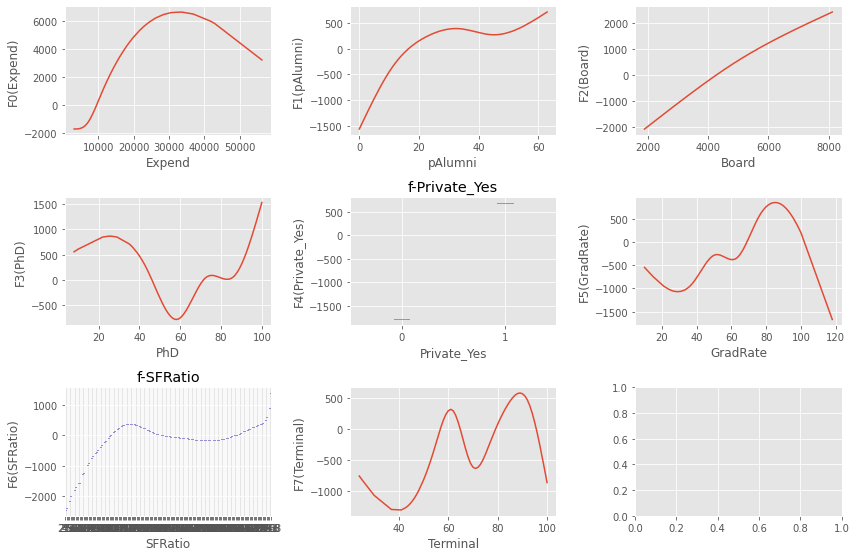

In [77]:
names = ['Expend', 'pAlumni', 'Board','PhD' ,'Private_Yes', 'GradRate', 'SFRatio', 'Terminal']
gam_plot(y_train, design, gam, names)

**(c)** Evalúe el modelo obtenido en el conjunto de prueba y explique los resultados obtenidos.

In [81]:
design2 = dmatrix("cr(Expend, df=4, constraints='center') + cr(pAlumni, df=5, constraints='center') + cr(Board, df=3, constraints='center') + cr(PhD, df=5, constraints='center') + Private_Yes + cr(GradRate, df=6,constraints='center') + cr(SFRatio, df=7,constraints='center') + cr(Terminal, df=8,constraints='center')",
                 data={"Expend":y_test.Expend, "pAlumni": y_test.pAlumni,"Board": y_test.Board,"PhD": y_test.PhD, "Private_Yes": y_test.Private_Yes, "GradRate": y_test.GradRate, "SFRatio": y_test.SFRatio, "Terminal": y_test.Terminal}, return_type="dataframe")

y_pred = gam.predict(design2)



In [83]:
r2_score(X_test[['Outstate']], y_pred)

0.7131178844534003

Obtuvimos que el modelo gam  tiene una precision del 71.3% con respecto al conjunto de prueba, con lo cual podemos decir que es bueno.

**(d)** ¿Para qué variables, si las hay, hay evidencia de una relación no lineal con la respuesta?

Observando las graficas dadas en el punto b, podemos decir que las variables Expend, pAlumni, PhD, GrandRate, SfRation y Terminal se evidencia una relación no lineal con la variable respuesta, debido a que la distribución de los datos con respecto a las funciones suavizadas de splines naturales cubicos.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=ab22eaaf-06f3-405f-9fcb-14fedb95aa5f' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>